In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

plt.rcParams['figure.figsize'] = [5.0, 4.0]
plt.rcParams['figure.dpi'] = 120

# Loading data

In [2]:
X_train_full = pd.read_csv('data\\training_set_features.csv', index_col = 'respondent_id')
y_train_full = pd.read_csv('data\\training_set_labels.csv', index_col = 'respondent_id')

Joining X and y for plotting simplicity:

In [3]:
train_df = X_train_full.join(y_train_full)

In [4]:
X_test = pd.read_csv('data\\test_set_features.csv', index_col = 'respondent_id')

# Exploratory Data Analysis

In this notebook, we want to explore the data through statistics and visualizations that help us draw insight from the raw data which can then be applied to preprocessing and feature engineering to help increase the accuracy of our predictions.

Lets begin by dividing the features in *numerical* and *categorical* since these require different approaches to visualization:

In [5]:
categorical_cols = [col for col in X_train_full.columns if X_train_full[col].dtype == 'object']
numerical_cols = [col for col in X_train_full.columns if col not in categorical_cols]
target_cols = ['h1n1_vaccine', 'seasonal_vaccine']

We can immediately plot the distribution of the targets and the numerical features:

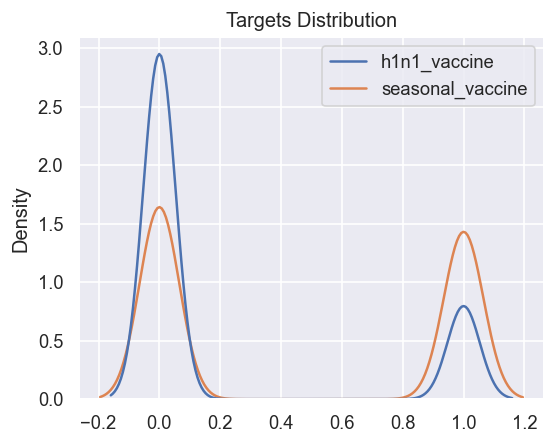

In [6]:
plt.figure()
plt.title('Targets Distribution')
sns.kdeplot(data=y_train_full);

From this image we can immediately see that someone is more likely to not take the H1N1 vaccine that to take it.

We can also see that the probability of taking the seasonal flu vaccine is more uniformly distributed.

Now we can start plotting the features.

Lets begin with the distribution of some categorical features for each of the targets. For that, we use the function:

In [106]:
def plot_bars(cols_to_plot):
    fig, axs = plt.subplots(len(cols_to_plot), 2, figsize = (10, 18))
    for i, col in enumerate(cols_to_plot):
        for j, target in enumerate(target_cols):
            counts = train_df[[target, col]].groupby([target, col]).size().unstack(target)
            counts_group = counts.sum(axis = 'columns')
            counts_percentage = counts.div(counts_group, axis = 'index')

            ax = axs[i][j]
            counts_percentage.plot(kind="barh", stacked=True, ax=ax, label = f'{target}')
            ax.invert_yaxis()
            ax.legend().remove()
            
        plt.tight_layout()
        axs[0][0].legend(loc = 'lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
        axs[0][1].legend(loc = 'lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')        

We want to replace some data names so that the plots have simpler axis labels:

In [81]:
train_df['age_group'].replace('65+ Years', '65+', inplace = True)
train_df['age_group'].replace('55 - 64 Years', '55+', inplace = True)
train_df['age_group'].replace('45 - 54 Years', '45+', inplace = True)
train_df['age_group'].replace('35 - 44 Years', '35+', inplace = True)
train_df['age_group'].replace('18 - 34 Years', '18+', inplace = True)

In [82]:
train_df['education'].replace('College Graduate', 'Very High', inplace = True)
train_df['education'].replace('Some College', 'High', inplace = True)
train_df['education'].replace('12 Years', 'Medium', inplace = True)
train_df['education'].replace('< 12 Years', 'Low', inplace = True)

In [83]:
train_df['income_poverty'].replace('Below Poverty', 'Low', inplace = True)
train_df['income_poverty'].replace('<= $75,000, Above Poverty', 'Medium', inplace = True)
train_df['income_poverty'].replace('> $75,000', 'High', inplace = True)

In [84]:
train_df['employment_status'].replace('Not in Labor Force', 'Not Working', inplace = True)

In [85]:
train_df['census_msa'].replace('MSA, Not Principle  City', 'NoPrinc.', inplace = True)
train_df['census_msa'].replace('MSA, Principle City', 'Princ.', inplace = True)

Finally, we choose the columns to plot. Notice we left out the columns *hhs_geo_region* and *employment_industry/occupation* since the data is coded and we probably wouldn't get much information from the plots.

In [107]:
cols_to_plot = ['age_group',
                'education',
                'race',
                'sex',
                'income_poverty',
                'marital_status',
                'rent_or_own',
                'employment_status',
                'census_msa']

And we make the plots:

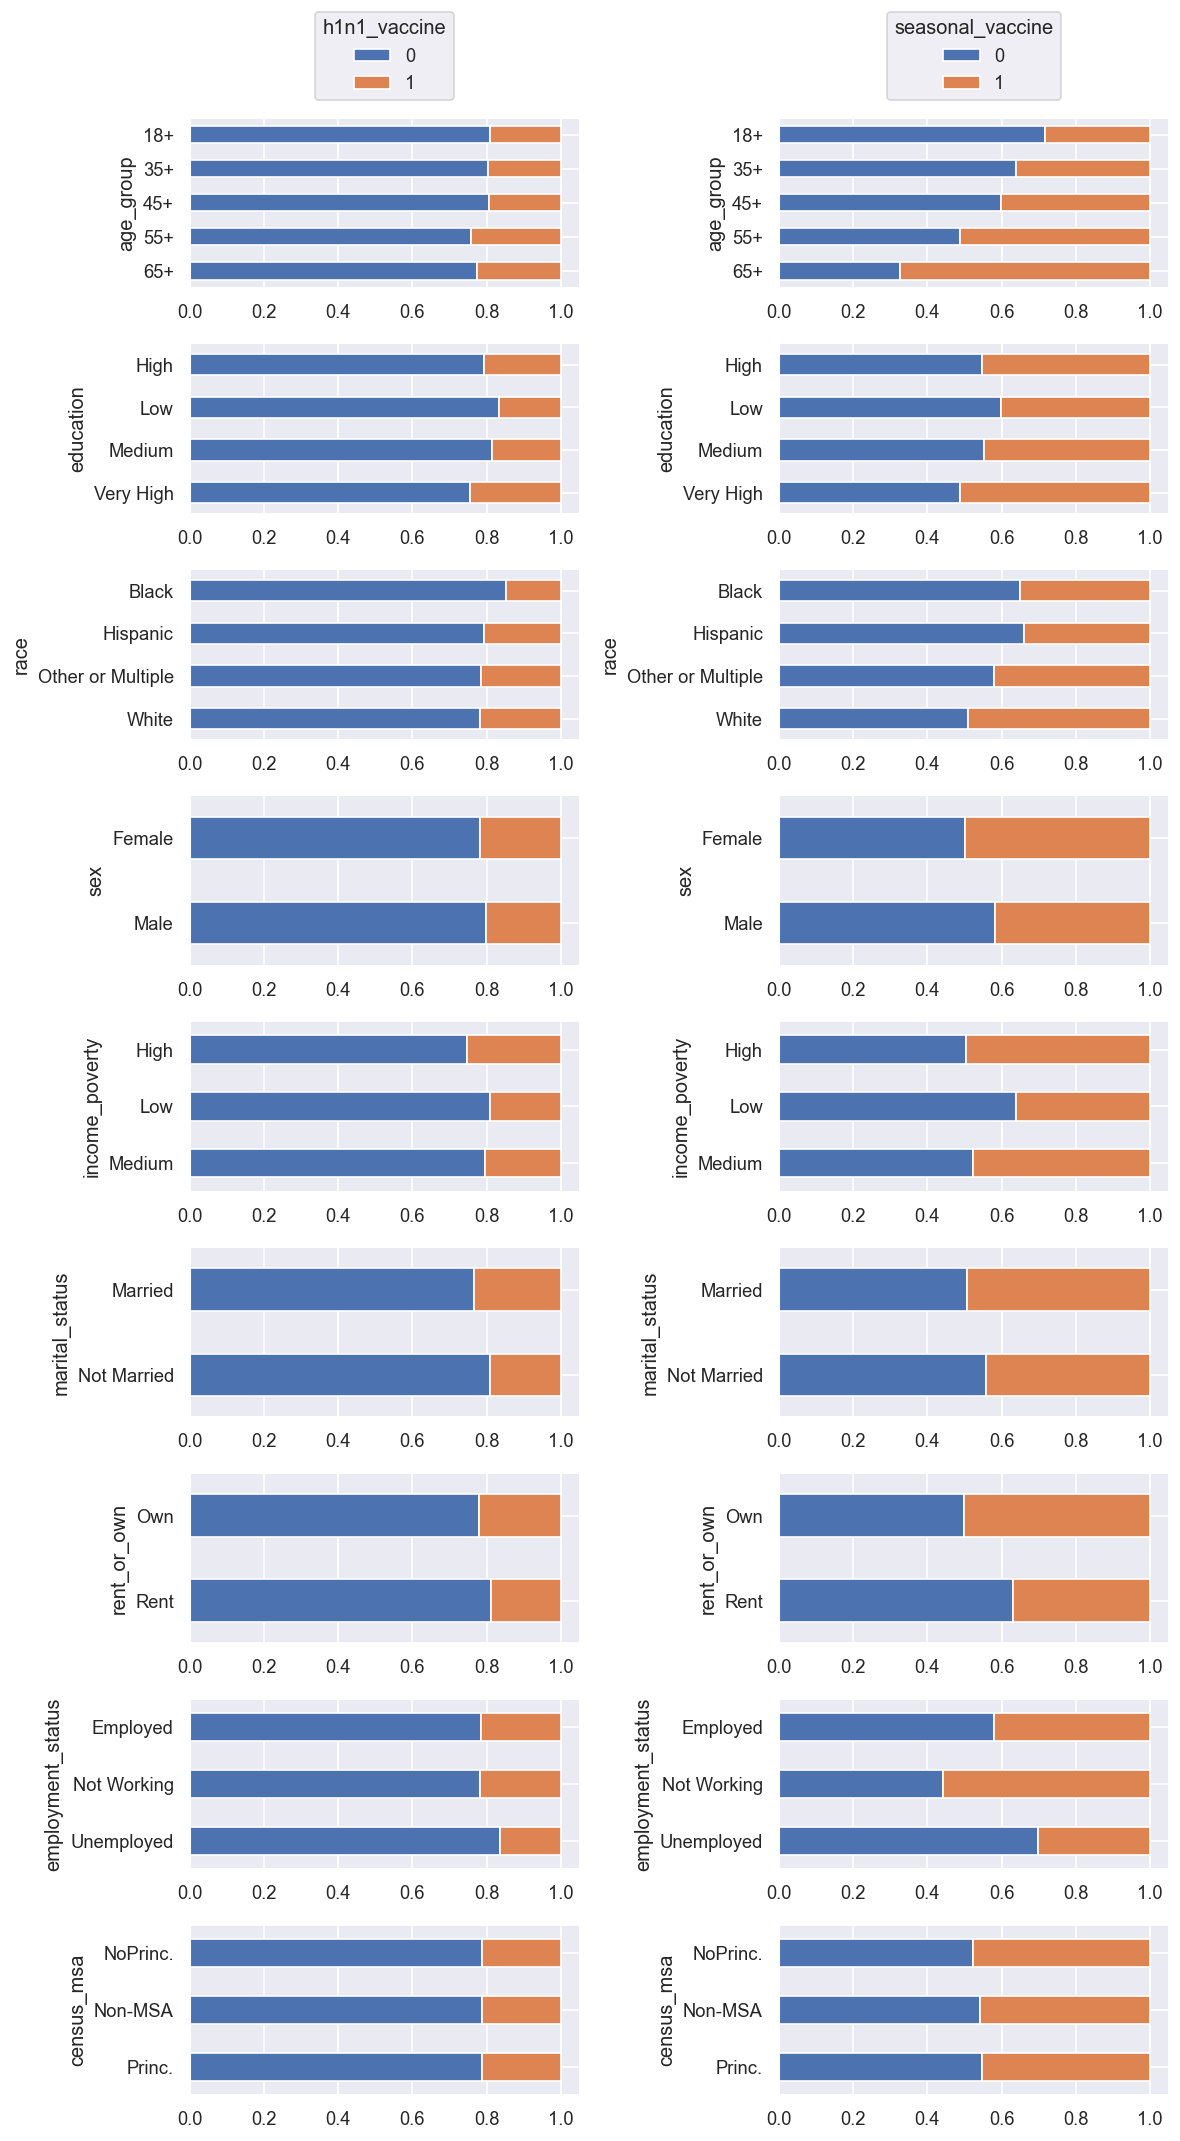

In [108]:
plot_bars(cols_to_plot)

We can draw some insights from this figure:
* The *age_group* feature shows that older people tended to get the seasonal vaccine more often than younger people - which is expected since people of higher age groups tend to be more affected and have more complications due to the flu. This correlation is not so obvious with the H1N1 vaccine.
* *education* seems to also be related to taking the vaccines - both the seasonal and the H1N1. This can possibly be attributed to more information about the deseases and the vaccines and thus a higher probability of wanting to protect themselves.
* Economic features such as *income_poverty* and *rent_or_own* show some correlation between a higher income and taking the vaccines - even though this is more prevalent in the case of the seasonal vaccine, it can also be minimally observed for the H1N1 vaccine.

*To be continued...*